## Imports

In [13]:
import csv
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sn
import pandas as pd
from sklearn.model_selection import learning_curve
from sklearn.metrics import *
from general_analysis import *
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from explore_hyperparameter import *
import math
from plot_learning_curve import *
import matplotlib.cm as cm
import time

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans as kmeans
from sklearn.mixture import GaussianMixture as GMM
from collections import defaultdict
from sklearn.metrics import adjusted_mutual_info_score as ami
import sys

import warnings
warnings.filterwarnings('ignore')


RANDOM_STATE = 5000 #to keep results consistent


## Load Data

### Separate X and y

In [14]:
data = pd.read_csv('letter-recognition.data')
X = data.values[:, 1:17]
y = data.values[:, 0]
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = RANDOM_STATE)

In [15]:
km = kmeans(random_state=RANDOM_STATE)
gmm = GMM(random_state=RANDOM_STATE)

In [16]:
clusters = [5, 10, 15, 20, 25, 30, 35, 40]
clusters = range(1, 41)
km_SSE = []
km_homogeneity = []
km_completeness = []

em_ll = []
em_homogeneity = []
em_completeness = []

for k in clusters:
    km.set_params(n_clusters=k)
    gmm.set_params(n_components=k)
    km.fit(X_train)
    gmm.fit(X_train)
    y_kmeans = km.predict(X_train)
    y_em = gmm.predict(X_train)
    km_SSE.append(-1 * km.score(X_train)) #sum of squared errors
    km_homogeneity.append(homogeneity_score(y_train, y_kmeans))
    km_completeness.append(completeness_score(y_train, y_kmeans))
    em_ll.append(gmm.score(X_train)) #log likelihood
    em_homogeneity.append(homogeneity_score(y_train, y_em))
    em_completeness.append(completeness_score(y_train, y_em))


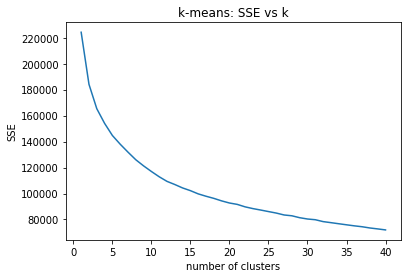

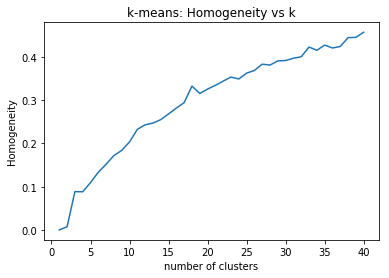

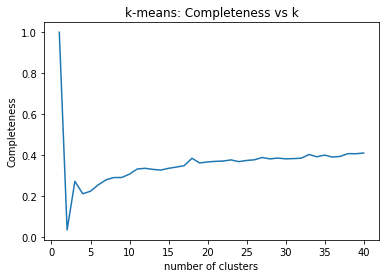

In [20]:
plt.figure(1)
plt.plot(clusters, km_SSE)
plt.title('k-means: SSE vs k')
plt.xlabel('number of clusters')
plt.ylabel('SSE')
plt.savefig('letters_km_sse.png')

plt.figure(2)
plt.plot(clusters, km_homogeneity)
plt.xlabel('number of clusters')
plt.ylabel('Homogeneity')
plt.title('k-means: Homogeneity vs k')
plt.savefig('letters_km_homo.png')

plt.figure(3)
plt.plot(clusters, km_completeness)
plt.xlabel('number of clusters')
plt.ylabel('Completeness')
plt.title('k-means: Completeness vs k')
plt.savefig('letters_km_complete.png')


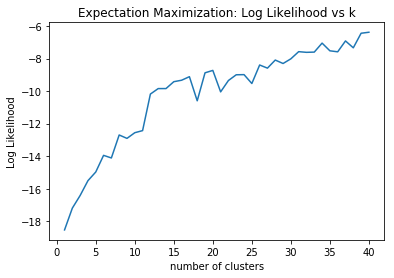

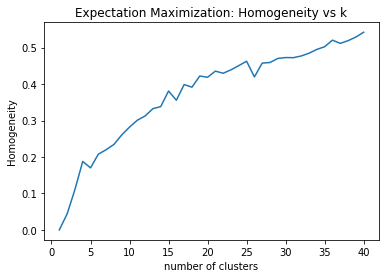

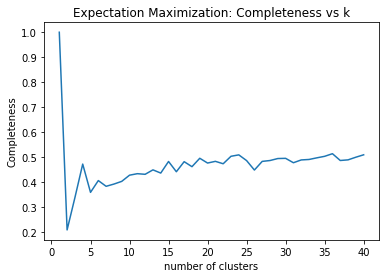

In [19]:
plt.figure(1)
plt.plot(clusters, em_ll)
plt.title('Expectation Maximization: Log Likelihood vs k')
plt.xlabel('number of clusters')
plt.ylabel('Log Likelihood')
plt.savefig('letters_em_ll.png')

plt.figure(2)
plt.plot(clusters, em_homogeneity)
plt.xlabel('number of clusters')
plt.ylabel('Homogeneity')
plt.title('Expectation Maximization: Homogeneity vs k')
plt.savefig('letters_em_homo.png')

plt.figure(3)
plt.plot(clusters, em_completeness)
plt.xlabel('number of clusters')
plt.ylabel('Completeness')
plt.title('Expectation Maximization: Completeness vs k')
plt.savefig('letters_em_complete.png')


For n_clusters = 5 The average silhouette_score is : 0.14075738178171737
For n_clusters = 10 The average silhouette_score is : 0.14097566877380743
For n_clusters = 15 The average silhouette_score is : 0.146606381233756
For n_clusters = 20 The average silhouette_score is : 0.1485478549973985
For n_clusters = 25 The average silhouette_score is : 0.14792438615128145
For n_clusters = 30 The average silhouette_score is : 0.15010082490777282


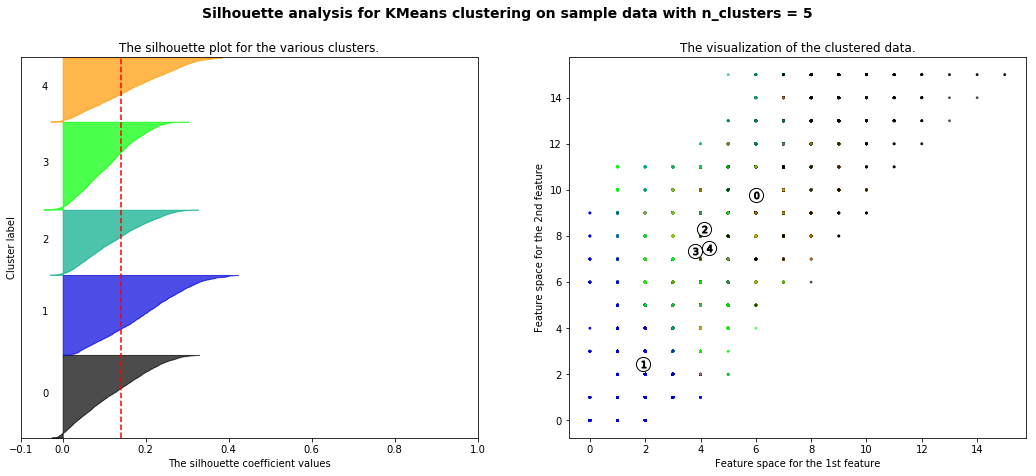

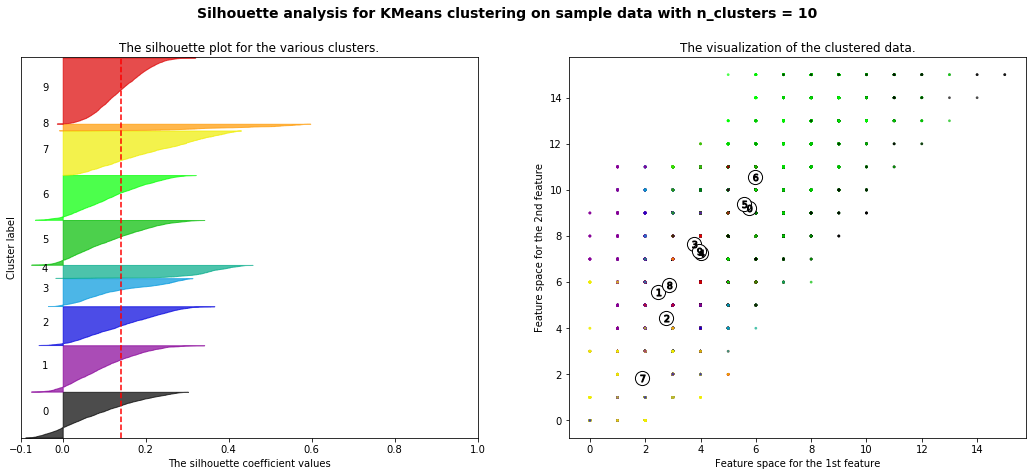

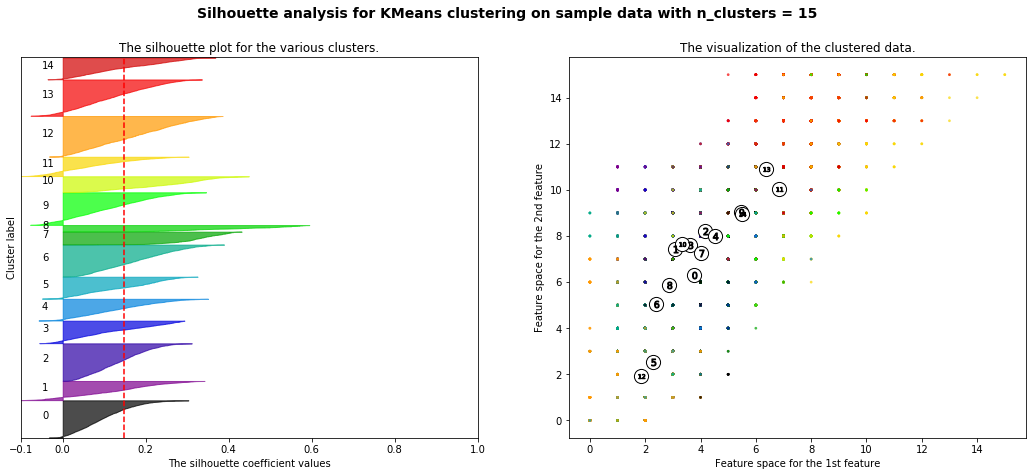

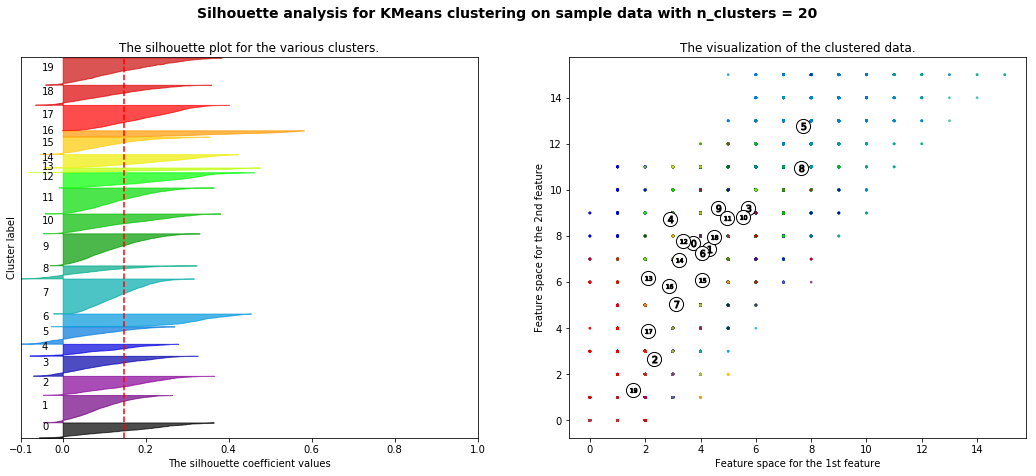

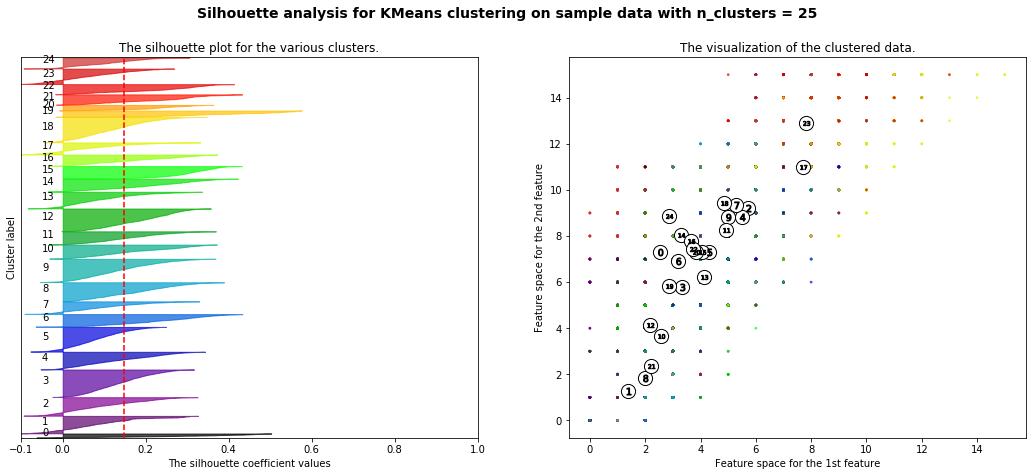

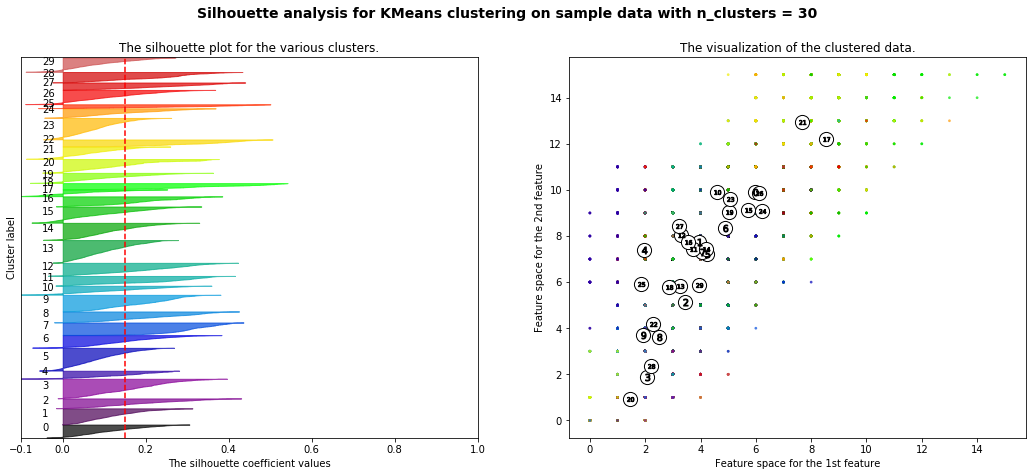

In [12]:
#range_n_clusters = range(2, 41)
range_n_clusters = [5, 10, 15, 20, 25, 30]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = kmeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()